In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

In [44]:
df = pd.read_csv("data.csv", sep=";")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Mapping Course

In [45]:
courses = np.unique(df["Course"])

# Tạo ánh xạ từ giá trị cũ sang giá trị mới (1 đến len(courses))
mapping = {val: idx + 1 for idx, val in enumerate(np.sort(courses))}
df['Course'] = df['Course'].map(mapping)

df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,2,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,11,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,15,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,3,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Encode target

In [46]:
def encode_target(value):
    if value == "Enrolled":
        return (1, 0, 0)
    if value == "Dropout":
        return (0, 1, 0)
    return (0, 0, 1)


# Defining the input and output vector

In [47]:
y = np.array([list(encode_target(yi)) for yi in df.iloc[:, -1]], dtype=np.float64)
X = df.iloc[:, :-1].to_numpy(dtype=np.float64)

In [48]:
X_y = np.hstack((X, y))

N = df.shape[0]
X_y_train, X_y_test = np.split(X_y, [int(0.8 * N)])
X_y_train.shape, X_y_test.shape

((3539, 39), (885, 39))

In [49]:
X_train, X_test = X_y_train[:, :-3], X_y_test[:, :-3]

X_train.shape, X_test.shape

((3539, 36), (885, 36))

In [50]:
y_train, y_test = X_y_train[:, -3:], X_y_test[:, -3:]

y_train.shape, y_test.shape

((3539, 3), (885, 3))

# Normalizing X

In [51]:
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)


# Softmax Regression

In [52]:
from tqdm import tqdm

class SoftmaxRegression:
    def __init__(self, epoch=100, lr=0.01):
        self.epoch = epoch
        self.lr = lr
        self.losses = []
        self.metrics = []

    def softmax(self, z):
        z -= np.max(z, axis=-1, keepdims=True)  # Tránh overflow
        exp_z = np.exp(z)
        return exp_z / (np.sum(exp_z, axis=-1, keepdims=True) + 1e-6)

    def loss_fn(self, y, y_hat):
        return -np.mean(np.sum(y * np.log(y_hat + 1e-6), axis=-1))

    def accuracy(self, y, y_hat):
        return (1 - np.abs(y - y_hat)).mean()

    def fit(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        n_classes = y.shape[1]
        
        self.theta = np.zeros((d, n_classes), dtype=np.float64)

        with tqdm(range(self.epoch), desc="Training") as pb:
            for e in pb:
                pb.set_description(f"Epoch {e + 1}/{self.epoch}")
                s = self.predict(X)
                gradient = (1/n) * np.dot(X.T, (s - y)) # (d, n_classes)
                self.theta -= self.lr * gradient

                # evaluating
                s = self.predict(X)
                loss = self.loss_fn(y, s)
                acc = self.accuracy(y.argmax(axis = -1), s.argmax(axis = -1))

                pb.set_postfix({
                    "loss": f"{loss:.4f}",
                    "acc": f"{acc:.4f}"
                })

                self.losses.append(loss)
                self.metrics.append(acc)

    def predict(self, X):
        z = np.matmul(X, self.theta) # (n, n_classes)
        y_hat = self.softmax(z)

        return y_hat



In [53]:
logistic_reg = SoftmaxRegression(50, 0.01)


In [54]:
logistic_reg.fit(X_train, y_train)

Epoch 50/50: 100%|██████████| 50/50 [00:01<00:00, 42.00it/s, loss=0.8850, acc=0.6132]


# Visualize lossing

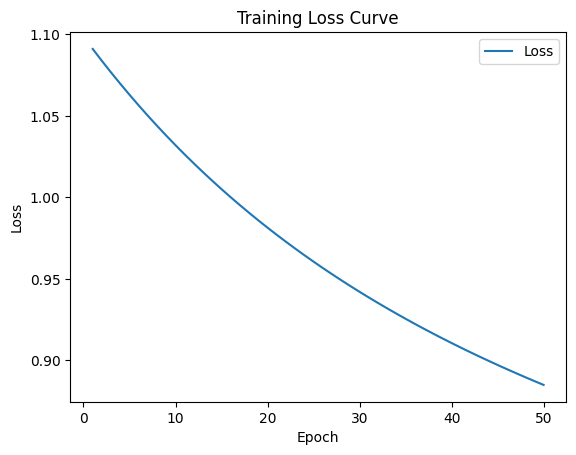

In [55]:
    
plt.plot(range(1, len(logistic_reg.losses) + 1), logistic_reg.losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
